In [2]:
import navis
import navis.interfaces.microns as mi

In [10]:
# Initialize the client for the 65 part of cortical mm^3 (i.e. "Minnie")
client = mi.get_cave_client(datastack='cortex65')

# Fetch available annotation tables
client.materialize.get_tables()

['nucleus_detection_v0',
 'synapses_pni_2',
 'nucleus_neuron_svm',
 'proofreading_status_public_release',
 'func_unit_em_match_release',
 'allen_soma_ei_class_model_v1',
 'allen_visp_column_soma_coarse_types_v1']

In [16]:
ct = client.materialize.query_table('allen_soma_ei_class_model_v1')
ct.head()

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,485509,t,aibs_coarse_excitatory,excitatory,103588564537113366,864691136740606812,"[282608, 103808, 20318]"
1,113721,t,aibs_coarse_excitatory,excitatory,79951332685465031,864691135366988025,"[110208, 153664, 23546]"
2,263203,t,aibs_coarse_excitatory,excitatory,87694643458256575,864691135181741826,"[166512, 174176, 24523]"
3,456177,t,aibs_coarse_excitatory,excitatory,102677963354799688,864691135337690598,"[275616, 135120, 24873]"
4,364447,t,aibs_coarse_excitatory,excitatory,94449079618306553,864691136883828334,"[216064, 166800, 15025]"


In [17]:
ct.cell_type.unique()

array(['excitatory', 'inhibitory'], dtype=object)

In [25]:
# Fetch proof-reading status
pr = client.materialize.query_table('proofreading_status_public_release')
pr.head()

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,1,t,89529934389098311,864691136296964635,864691136296964635,extended,non,"[179808, 216672, 23361]"
1,2,t,90584228533843146,864691136311986237,864691136311986237,extended,non,"[187840, 207232, 22680]"
2,3,t,89528353773943370,864691135355207119,864691135355207119,extended,non,"[180016, 204592, 22798]"
3,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[191424, 209888, 22845]"
4,5,t,88897234233461709,864691136422983727,864691136422983727,extended,non,"[175248, 220944, 23561]"


In [29]:
# Subset to those neurons that have been proof read
proofread = pr[pr.status_dendrite.isin(['extented', 'clean']) & pr.status_axon.isin(['extented', 'clean'])].pt_root_id.values

ct = ct[ct.pt_root_id.isin(proofread)]
ct.shape

(167, 7)

In [30]:
# Pick 20 "root IDs" (sometimes also called segment IDs) each
inh_ids = ct[ct.cell_type == 'inhibitory'].pt_root_id.values[: 20]
exc_ids = ct[ct.cell_type == 'excitatory'].pt_root_id.values[: 20]

In [33]:
# Fetch neurons
inh = mi.fetch_neurons(inh_ids, lod=3)
exc = mi.fetch_neurons(exc_ids, lod=3)

# Inspect
inh

Fetching:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching:   0%|          | 0/20 [00:00<?, ?it/s]

,type,name,id,units,n_vertices,n_faces
0,navis.MeshNeuron,None,864691135700443515,1 nanometer,59139,120939
1,navis.MeshNeuron,None,864691135974528623,1 nanometer,31271,64092
...,...,...,...,...,...,...
18,navis.MeshNeuron,None,864691135446864980,1 nanometer,64187,131427
19,navis.MeshNeuron,None,864691135428608048,1 nanometer,82187,168650


In [37]:
# Reduce face counts to 1/3 of original
inh_ds = navis.simplify_mesh(inh, F=1/3)
exc_ds = navis.simplify_mesh(exc, F=1/3)

# Inspect (note the lower face/vertex counts)
inh_ds

,type,name,id,units,n_vertices,n_faces
0,navis.MeshNeuron,None,864691135700443515,1 nanometer,23082,40313
1,navis.MeshNeuron,None,864691135974528623,1 nanometer,12688,21364
...,...,...,...,...,...,...
18,navis.MeshNeuron,None,864691135446864980,1 nanometer,25401,43809
19,navis.MeshNeuron,None,864691135428608048,1 nanometer,32873,56215


In [ ]:
# Create some colors: reds for excitatory, blue for inhibitory
import seaborn as sns
colors = {n.id: sns.color_palette('Reds', len(exc))[i] for i, n in enumerate(exc)}
colors.update({n.id: sns.color_palette('Blues', len(inh))[i] for i, n in enumerate(inh)})

# Plot the first 10 neurons each
fig = navis.plot3d([inh_ds[:10], exc_ds[:10]], color=colors)

In [49]:
inh_sk = navis.skeletonize(inh, parallel=True)
exc_sk = navis.skeletonize(exc, parallel=True)

# Inspect 
inh_sk

Skeletonizing:   0%|          | 0/20 [00:00<?, ?it/s]

Skeletonizing:   0%|          | 0/20 [00:00<?, ?it/s]

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,None,864691135700443515,14557,None,353,430,2.273385e+07,7978,1 nanometer
1,navis.TreeNeuron,None,864691135974528623,7643,None,312,335,1.208148e+07,4073,1 nanometer
...,...,...,...,...,...,...,...,...,...,...
18,navis.TreeNeuron,None,864691135446864980,15049,None,382,433,2.369541e+07,6270,1 nanometer
19,navis.TreeNeuron,None,864691135428608048,20007,None,584,648,3.176056e+07,9397,1 nanometer


In [52]:
# Plot one example (zoom in for details)
fig = navis.plot3d([inh_sk[0], inh[0]], color=[(1, 0, 0), (1, 1, 1, .5)])

In [55]:
# Create a combined DataFrame 
import pandas as pd 

inh_stats = inh_sk.summary()
inh_stats['type'] = 'inhibitory'

exc_stats = exc_sk.summary()
exc_stats['type'] = 'excitatory'

stats = pd.concat([inh_stats, exc_stats], axis=0)
stats.head()

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,inhibitory,None,864691135700443515,14557,None,353,430,2.273385e+07,7978,1 nanometer
1,inhibitory,None,864691135974528623,7643,None,312,335,1.208148e+07,4073,1 nanometer
2,inhibitory,None,864691135113360025,9893,None,262,317,1.565088e+07,6036,1 nanometer
3,inhibitory,None,864691135994731946,6008,None,470,193,9.496682e+06,3768,1 nanometer
4,inhibitory,None,864691136521811345,3174,None,280,115,5.027150e+06,2008,1 nanometer


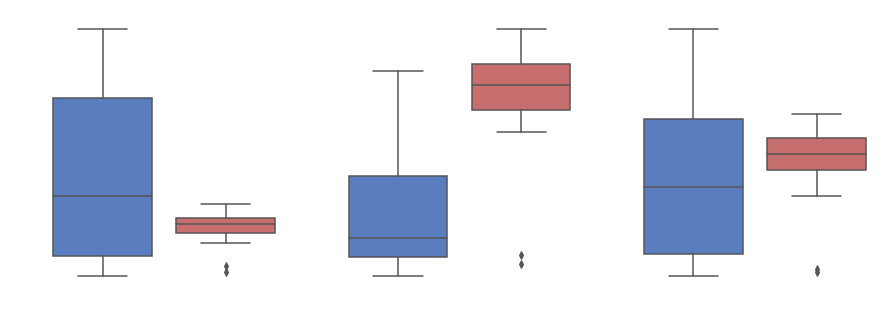

In [91]:
import matplotlib.pyplot as plt

sns.set_color_codes('muted')
plt.style.use('dark_background')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_color((0,0,0,0))

for col, label, ax in zip(['cable_length', 'n_branches', 'n_leafs'],
                          ['cable length  [nm]', '# of branch points', '# of leafs (tips)'],
                          axes):
    sns.boxplot(data=stats, y=col, x='type', ax=ax, palette=['b', 'r'])
    ax.set_ylabel(label)
    ax.set_xlabel('')
    ax.patch.set_color((0,0,0,0))
    
sns.despine(trim=True)